In [4]:
pip install textblob

You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
# Load necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import os
import re
import string
import unicodedata
import warnings

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from textblob import TextBlob, Word

# Ignore warnings
warnings.filterwarnings('ignore')

# List files in current working directory
print("Files in current directory:", os.listdir("."))

# Download necessary NLTK datasets (only needs to be run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For lemmatizer


Files in current directory: ['app.py', 'de&n.ipynb', 'models', 'Templates', 'uploads']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
#importing the training data
imdb_data = pd.read_csv(r'C:\Users\User\Downloads\archive (2)\IMDB Dataset.csv')

print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [11]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

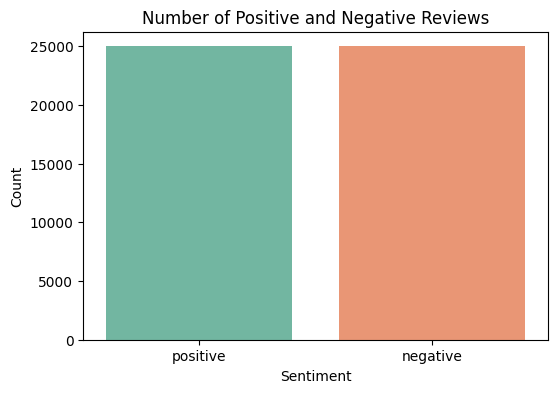

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=imdb_data, palette='Set2')
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [6]:
imdb_data.isnull().sum()


review       0
sentiment    0
dtype: int64

In [11]:
print(imdb_data['sentiment'].unique())


['positive' 'negative']


In [15]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(
    imdb_data['review'],
    imdb_data['sentiment'],
    test_size=0.2,              # 20% test, 80% train
    random_state=42,           # for reproducibility
    stratify=imdb_data['sentiment']  # keeps sentiment balance
)


In [16]:
from nltk.corpus import stopwords

# Get standard stopwords
stopword_list = stopwords.words('english')

# Retain important negation words
negation_words = ['no', 'not', 'nor', 'never', "n't"]
custom_stopwords = [word for word in stopword_list if word not in negation_words]


In [17]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [18]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [19]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [21]:
# Set English stopwords but exclude important negations
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer

tokenizer = ToktokTokenizer()

# Step 1: Get default stopwords
default_stopwords = set(stopwords.words('english'))

# Step 2: Remove negation words from stopword list
negation_words = {'no', 'not', 'nor', 'never', "n't"}
custom_stopwords = default_stopwords - negation_words

# Step 3: Redefine your stopword removal function
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in custom_stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in custom_stopwords]
    
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply it to your dataset
imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)


In [25]:
from textblob import TextBlob

norm_train_reviews = imdb_data.review[:40000]  # Make sure it's defined

sample_review = norm_train_reviews[0]
corrected = TextBlob(sample_review).correct()

print("Before:", sample_review)
print("After:", corrected)


Before: one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi not show faint heart timid thi show pull no punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci not high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc not violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack s

In [26]:


sample_test_review = imdb_data.review[45005]
print("Original:", sample_test_review)

corrected = TextBlob(sample_test_review).correct()
print("Corrected:", corrected)


Original: read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still not get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook not comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 no way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 beca

In [71]:
# Simple custom rule
def handle_negation(text):
    tokens = text.split()
    new_tokens = []
    negate = False
    for token in tokens:
        if token in ['not', 'no', 'never', "n't"]:
            negate = True
            continue
        if negate:
            new_tokens.append('NOT_' + token)
            negate = False
        else:
            new_tokens.append(token)
    return ' '.join(new_tokens)

# Example: "not good" → "NOT_good"


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# Redefine normalized train and test reviews
norm_train_reviews = imdb_data.review[:40000]
norm_test_reviews = imdb_data.review[40000:]

# Create CountVectorizer with n-grams (1 to 3)
cv = CountVectorizer(min_df=1, max_df=1.0, binary=False, ngram_range=(1, 3))

# Transform the text data
cv_train_reviews = cv.fit_transform(norm_train_reviews)
cv_test_reviews = cv.transform(norm_test_reviews)

# Output shapes
print('BOW_cv_train:', cv_train_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)




BOW_cv_train: (40000, 7016324)
BOW_cv_test: (10000, 7016324)


In [30]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [31]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [32]:
import numpy as np

# Flatten the arrays (if needed)
train_sentiments = train_sentiments.ravel()
test_sentiments = test_sentiments.ravel()

# Count 0s and 1s in both sets
train_counts = np.bincount(train_sentiments)
test_counts = np.bincount(test_sentiments)

print("Train Sentiments:")
print(f"Negative (0): {train_counts[0]}")
print(f"Positive (1): {train_counts[1]}")

print("\nTest Sentiments:")
print(f"Negative (0): {test_counts[0]}")
print(f"Positive (1): {test_counts[1]}")


Train Sentiments:
Negative (0): 20007
Positive (1): 19993

Test Sentiments:
Negative (0): 4993
Positive (1): 5007


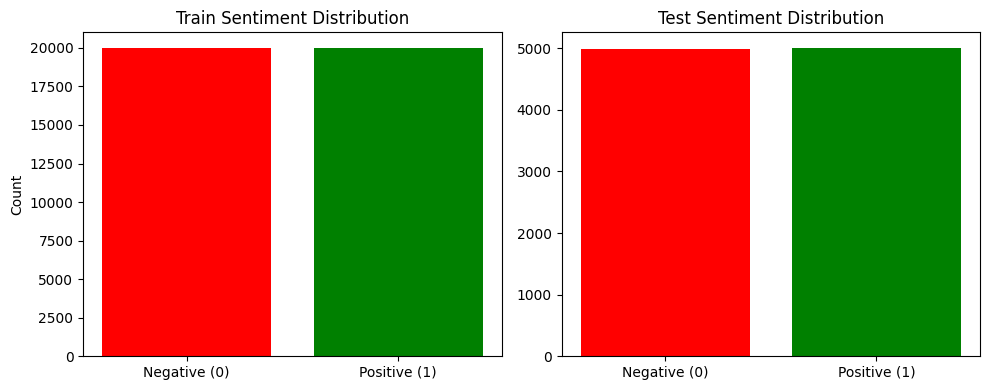

In [33]:
import matplotlib.pyplot as plt

labels = ['Negative (0)', 'Positive (1)']

# Plot Train Sentiments
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, train_counts, color=['red', 'green'])
plt.title('Train Sentiment Distribution')
plt.ylabel('Count')

# Plot Test Sentiments
plt.subplot(1, 2, 2)
plt.bar(labels, test_counts, color=['red', 'green'])
plt.title('Test Sentiment Distribution')

plt.tight_layout()
plt.show()


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tv = TfidfVectorizer(min_df=2, max_df=0.9, max_features=50000, ngram_range=(1, 2))

# Fit on training data and transform both train and test sets
tv_train_reviews = tv.fit_transform(norm_train_reviews)
tv_test_reviews = tv.transform(norm_test_reviews)


In [35]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

# Train using Bag of Words
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
print("Logistic Regression (BoW) model trained.")

# Train using TF-IDF
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print("Logistic Regression (TF-IDF) model trained.")


Logistic Regression (BoW) model trained.
Logistic Regression (TF-IDF) model trained.


In [36]:
from sklearn.linear_model import LogisticRegression

# Create and train separate models
lr_bow = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lr_bow.fit(cv_train_reviews, train_sentiments)

lr_tfidf = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lr_tfidf.fit(tv_train_reviews, train_sentiments)


LogisticRegression(C=1, max_iter=500, random_state=42)

In [38]:
# Predict using BoW model
lr_bow_predict = lr_bow.predict(cv_test_reviews)

# Predict using TF-IDF model
lr_tfidf_predict = lr_tfidf.predict(tv_test_reviews)


In [39]:
from sklearn.metrics import accuracy_score

#Accuracy score for bag of words
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print("lr_bow_score :", lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("lr_tfidf_score :", lr_tfidf_score)


lr_bow_score : 0.9018
lr_tfidf_score : 0.9028


In [40]:
from sklearn.metrics import classification_report

# Classification report for BoW model
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names=['Negative', 'Positive'])
print("BoW Model Report:\n", lr_bow_report)

# Classification report for TF-IDF model
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names=['Negative', 'Positive'])
print("TF-IDF Model Report:\n", lr_tfidf_report)


BoW Model Report:
               precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      4993
    Positive       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

TF-IDF Model Report:
               precision    recall  f1-score   support

    Negative       0.91      0.90      0.90      4993
    Positive       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [41]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4532  475]
 [ 507 4486]]
[[4544  463]
 [ 509 4484]]


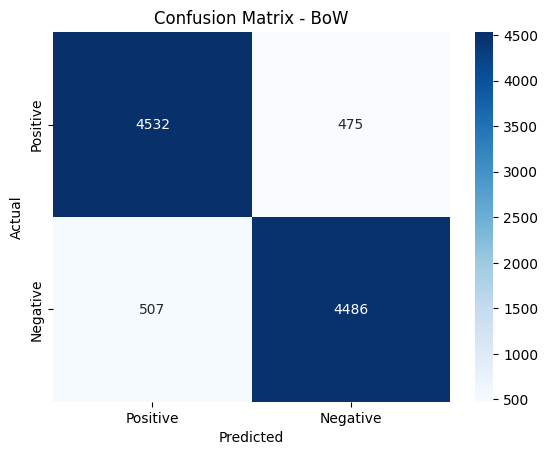

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title("Confusion Matrix - BoW")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [43]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [44]:
from sklearn.linear_model import SGDClassifier

# Train on BoW features
svm_bow = SGDClassifier(loss='hinge', max_iter=500, random_state=42)
svm_bow.fit(cv_train_reviews, train_sentiments)

# Train on TF-IDF features
svm_tfidf = SGDClassifier(loss='hinge', max_iter=500, random_state=42)
svm_tfidf.fit(tv_train_reviews, train_sentiments)


SGDClassifier(max_iter=500, random_state=42)

In [45]:
# Predict using BoW model
svm_bow_predict = svm_bow.predict(cv_test_reviews)

# Predict using TF-IDF model
svm_tfidf_predict = svm_tfidf.predict(tv_test_reviews)


In [47]:
from sklearn.metrics import accuracy_score

print("SVM BoW Accuracy:", accuracy_score(test_sentiments, svm_bow_predict))
print("SVM TF-IDF Accuracy:", accuracy_score(test_sentiments, svm_tfidf_predict))


SVM BoW Accuracy: 0.8978
SVM TF-IDF Accuracy: 0.9028


In [49]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.91      0.89      0.90      4993
    Negative       0.89      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

              precision    recall  f1-score   support

    Positive       0.91      0.90      0.90      4993
    Negative       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [50]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4551  456]
 [ 566 4427]]
[[4538  469]
 [ 503 4490]]


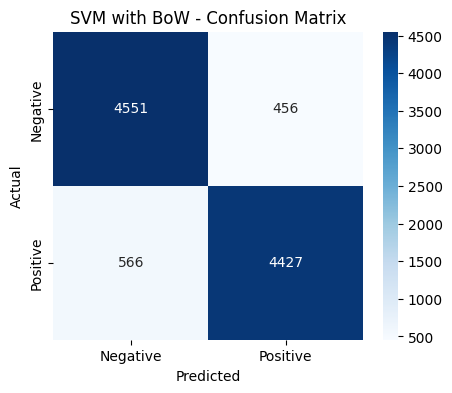

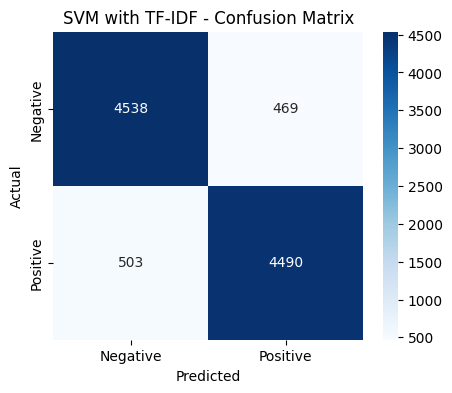

In [51]:
def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot for SVM BoW
plot_confusion(cm_bow, "SVM with BoW - Confusion Matrix")

# Plot for SVM TF-IDF
plot_confusion(cm_tfidf, "SVM with TF-IDF - Confusion Matrix")

In [52]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes model
mnb = MultinomialNB()

# Fitting MNB for Bag of Words features
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)
print("MNB BoW model trained.")

# Fitting MNB for TF-IDF features
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print("MNB TF-IDF model trained.")


MNB BoW model trained.
MNB TF-IDF model trained.


In [53]:
from sklearn.naive_bayes import MultinomialNB

# Two separate models
mnb_bow = MultinomialNB()
mnb_tfidf = MultinomialNB()

# Fit separately
mnb_bow.fit(cv_train_reviews, train_sentiments)
mnb_tfidf.fit(tv_train_reviews, train_sentiments)


MultinomialNB()

In [54]:
# Predict using each model with matching feature space
mnb_bow_preds = mnb_bow.predict(cv_test_reviews)
mnb_tfidf_preds = mnb_tfidf.predict(tv_test_reviews)


In [55]:
from sklearn.metrics import accuracy_score

print("MNB BoW Accuracy:", accuracy_score(test_sentiments, mnb_bow_preds))
print("MNB TF-IDF Accuracy:", accuracy_score(test_sentiments, mnb_tfidf_preds))


MNB BoW Accuracy: 0.8873
MNB TF-IDF Accuracy: 0.8849


In [56]:
from sklearn.metrics import classification_report

# Classification report for BoW model
mnb_bow_report = classification_report(test_sentiments, mnb_bow_preds, target_names=['Positive', 'Negative'])
print("Classification Report - MultinomialNB with BoW:\n", mnb_bow_report)

# Classification report for TF-IDF model
mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_preds, target_names=['Positive', 'Negative'])
print("Classification Report - MultinomialNB with TF-IDF:\n", mnb_tfidf_report)


Classification Report - MultinomialNB with BoW:
               precision    recall  f1-score   support

    Positive       0.87      0.90      0.89      4993
    Negative       0.90      0.87      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Classification Report - MultinomialNB with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.89      0.88      0.88      4993
    Negative       0.88      0.89      0.89      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [58]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for BoW
cm_bow = confusion_matrix(test_sentiments, mnb_bow_preds, labels=[1, 0])
print("Confusion Matrix - MultinomialNB with BoW:\n", cm_bow)

# Confusion matrix for TF-IDF
cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_preds, labels=[1, 0])
print("Confusion Matrix - MultinomialNB with TF-IDF:\n", cm_tfidf)


Confusion Matrix - MultinomialNB with BoW:
 [[4358  649]
 [ 478 4515]]
Confusion Matrix - MultinomialNB with TF-IDF:
 [[4453  554]
 [ 597 4396]]


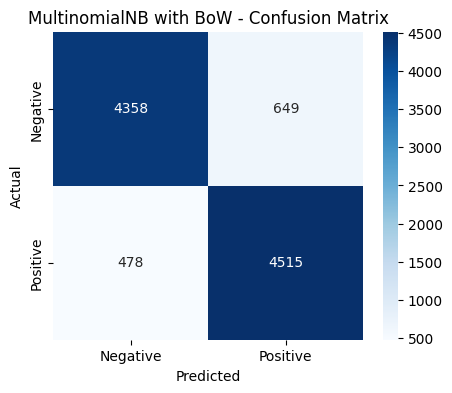

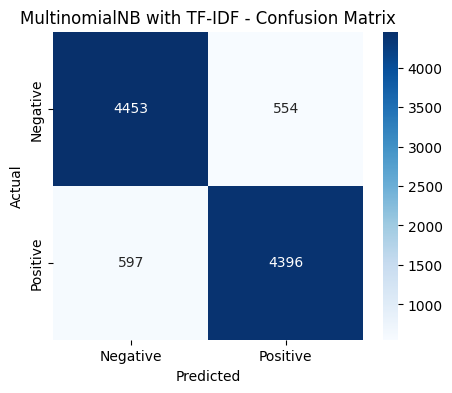

In [59]:
plot_confusion(cm_bow, "MultinomialNB with BoW - Confusion Matrix")
plot_confusion(cm_tfidf, "MultinomialNB with TF-IDF - Confusion Matrix")

<function matplotlib.pyplot.show(close=None, block=None)>

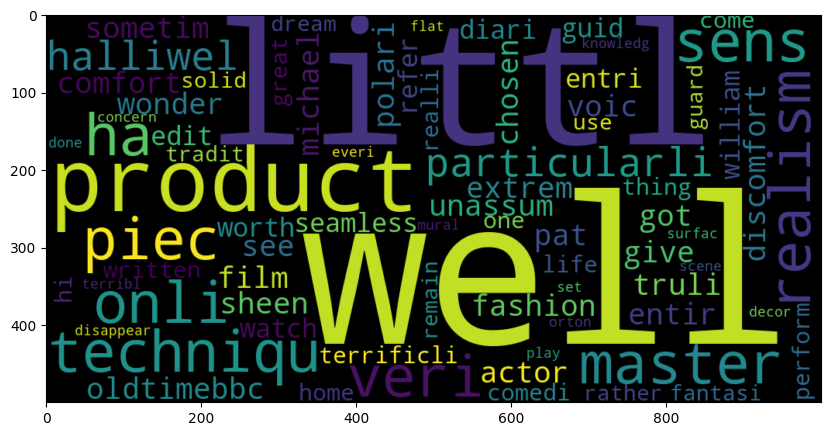

In [60]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

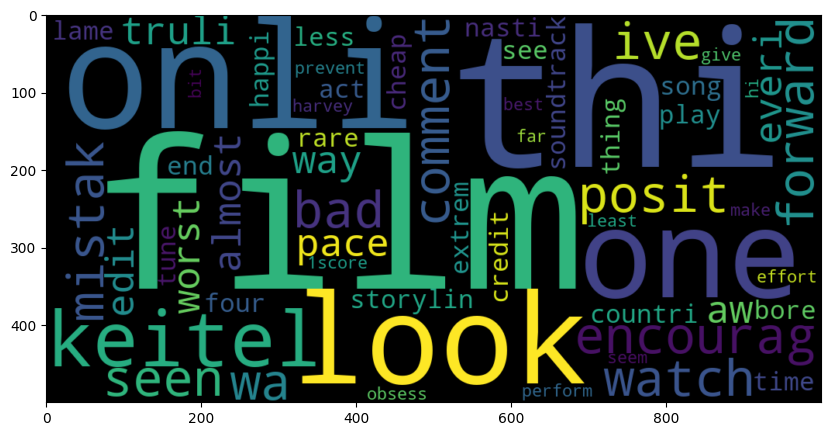

In [61]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [62]:
import os

# Create 'models' folder if it doesn't exist
os.makedirs("models", exist_ok=True)


In [69]:
import pickle

# Save models
pickle.dump(lr_bow, open('models/lr_bow.pkl', 'wb'))
pickle.dump(lr_tfidf, open('models/lr_tfidf.pkl', 'wb'))
pickle.dump(mnb_bow, open('models/mnb_bow.pkl', 'wb'))
pickle.dump(mnb_tfidf, open('models/mnb_tfidf.pkl', 'wb'))

# Save vectorizers
import pickle

# Save CountVectorizer with the expected name
pickle.dump(cv, open('models/cv_vectorizer.pkl', 'wb'))

# Save TfidfVectorizer with the expected name
pickle.dump(tv, open('models/tv_vectorizer.pkl', 'wb'))



In [64]:
import os
import pickle

os.makedirs("models", exist_ok=True)

# Save Logistic Regression (TF-IDF)
pickle.dump(lr_tfidf, open('models/lr_tfidf.pkl', 'wb'))

# Save TF-IDF vectorizer
pickle.dump(tv, open('models/tv.pkl', 'wb'))


In [66]:


# Save the model and vectorizer
pickle.dump(lr_bow, open('models/lr_bow.pkl', 'wb'))
pickle.dump(cv, open('models/cv_vectorizer.pkl', 'wb'))
